In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
# from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [3]:
torch.backends.cudnn.benchmark=True

## Data

In [4]:
PATH = Path('../data/all')

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [6]:
VEHICLES=10
ROADS=7
ROAD_LINES=6

In [7]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'
workers=7
random_crop=True
pseudo_label=False
val_folder = 'sample_test_sync'
S_PREFIX = '35-unet11-mini-pt2'

In [8]:
from torchvision.datasets.folder import pil_loader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TTF

### Create dataloader

In [9]:
class MatchedFilesDataset(Dataset):
    def __init__(self, fnames, y, tfms, path):
        self.path,self.fnames = path,fnames
        self.open_fn = pil_loader
        self.y=y
        self.open_y_fn = pil_loader
        assert(len(fnames)==len(y))
        
        self.n = self.get_n()
        self.c = self.get_c()
        self.tfms = tfms
        
    def get_x(self, i): return self.open_fn(os.path.join(self.path, self.fnames[i]))
    def get_y(self, i): return self.open_y_fn(os.path.join(self.path, self.y[i]))
    def get_n(self): return len(self.fnames)
    def get_c(self): return 2
    
    def get(self, tfms, x, y):
        for fn in tfms:
            #pdb.set_trace()
            x, y = fn(x, y)
        return (x, y)
    
    def __getitem__(self, idx):
        x,y = self.get_x(idx),self.get_y(idx)
        return self.get(self.tfms, x, y)
    
    def __len__(self): return self.n

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

In [10]:

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)
    
    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [11]:
def crop_bg_pil(x,y):
    w, h = x.size
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    pad_right=32-w%32
    return TTF.crop(x, top, 0, bot-top, w+pad_right), TTF.crop(y, top, 0, bot-top, w+pad_right)

In [12]:
class RHF(object):
    def __init__(self, p=0.5): self.p = p
    def __call__(self, x, y):
        if random.random() < self.p:
            return TTF.hflip(x), TTF.hflip(y)
        return x,y

In [13]:
class RR(object):
    def __init__(self, degrees=2): self.degrees = degrees
    def __call__(self, x, y):
        angle = random.uniform(-self.degrees, self.degrees)
        return TTF.rotate(x, angle), TTF.rotate(y, angle)

In [14]:
def tfm_x_wrapper(tfm):
    return lambda x,y: (tfm(x), y)

In [15]:
class RC():
    def __init__(self, targ_sz):
        self.targ_sz = targ_sz

    def __call__(self, x, y):
        rand_w = random.uniform(0, 1)
        rand_h = random.uniform(0, 1)
        w,h = x.size
        t_w,t_h = self.targ_sz
        start_x = np.floor(rand_w*(w-t_w)).astype(int)
        start_y = np.floor(rand_h*(h-t_h)).astype(int)
        return TTF.crop(x, start_y, start_x, t_h, t_w), TTF.crop(y, start_y, start_x, t_h, t_w)

In [16]:
def convert_y(y_img):
    yr = (y_img==ROADS) | (y_img==ROAD_LINES)
    yc = (y_img==VEHICLES)
    cutoff_y = int(yc.shape[0]*.87)
    yc[cutoff_y:,:] = 0
    return torch.from_numpy(np.stack((yc,yr)).astype(int))


def xy_tensor(x,y):
    y_img = np.array(y, np.int32, copy=False)
    return TTF.to_tensor(x), convert_y(y_img[:,:,0])

In [17]:
class RRC(transforms.RandomResizedCrop):
    def __call__(self, x, y):
        i, j, h, w = self.get_params(x, self.scale, self.ratio)
        x = TTF.resized_crop(x, i, j, h, w, self.size, self.interpolation)
        y = TTF.resized_crop(y, i, j, h, w, self.size, self.interpolation)
        return x, y

In [18]:
def torch_loader(f_ext, data_path, bs, size, workers=7, random_crop=False, pseudo_label=False, val_folder=None, val_bs=None):
    # Data loading code
    x_names = np.sort(np.array(glob(str(data_path/f'CameraRGB{f_ext}'/'*.png'))))
    y_names = np.sort(np.array(glob(str(data_path/f'CameraSeg{f_ext}'/'*.png'))))

    x_n = x_names.shape[0]
    val_idxs = list(range(x_n-300, x_n))
    
    if pseudo_label:
        x_names_test = np.sort(np.array(glob(f'../data/pseudo/CameraRGB{f_ext}/*.png')))
        y_names_test = np.sort(np.array(glob(f'../data/pseudo/CameraSeg{f_ext}/*.png')))
        x_names = np.concatenate((x_names, x_names_test))
        x_names = np.concatenate((y_names, y_names_test))
        print(f'Pseudo-Labels: {len(x_names_test)}')
    if val_folder:
        x_names_val = np.sort(np.array(glob(f'../data/{val_folder}/CameraRGB{f_ext}/*.png')))
        y_names_val = np.sort(np.array(glob(f'../data/{val_folder}/CameraSeg{f_ext}/*.png')))
        val_x,val_y = x_names_val, y_names_val
        trn_x,trn_y = x_names, y_names
        print(f'Val Labels:', len(val_x))
    else:
        ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
    print(f'Val x:{len(val_x)}, y:{len(val_y)}')
    print(f'Trn x:{len(trn_x)}, y:{len(trn_y)}')
    print(f'All x:{len(x_names)}')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    train_tfms = [
        crop_bg_pil,
        tfm_x_wrapper(transforms.ColorJitter(.2,.2,.2)),
#         tfm_x_wrapper(Lighting(0.1, __imagenet_pca['eigval'], __imagenet_pca['eigvec'])),
        RR(),
        RHF(),
#         RC((size,size)),
        xy_tensor,
        tfm_x_wrapper(normalize),
    ]
    if random_crop:
        train_tfms.insert(3,RRC(size, scale=(0.4, 1.0)))
    train_dataset = MatchedFilesDataset(trn_x, trn_y, train_tfms, path='')
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_tfms = [
        crop_bg_pil,
        xy_tensor,
        tfm_x_wrapper(normalize)
    ]
    val_dataset = MatchedFilesDataset(val_x, val_y, val_tfms, path='')
    if val_bs is None: val_bs = bs
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=val_bs, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    return data


In [19]:
def denorm(x):
    x_np = x.cpu().numpy()
    x_np = np.rollaxis(x_np, 0, 3)
    mean=np.array([0.4914 , 0.48216, 0.44653])
    std=np.array([0.24703, 0.24349, 0.26159])
    x_np = x_np*std+mean
    return x_np

### Visualize data

In [20]:
sz = 96
bs = 2
ext = '-150'
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

Val Labels: 400
Val x:400, y:400
Trn x:7280, y:7280
All x:7280


In [21]:
x,y = md.val_ds[259]

In [ ]:
plt.imshow(y[1])

In [ ]:
y.shape

In [ ]:
plt.imshow(y[1])

In [ ]:
x_out = denorm(x)

In [ ]:
plt.imshow(x_out)

In [ ]:
plt.imshow(y)

## U-net (ish)

In [20]:
from torchvision.models import vgg11_bn

In [21]:
def vgg11(pre): return children(vgg11_bn(pre))[0]

In [22]:
model_meta = {
    resnet18:[8,6], resnet34:[8,6], resnet50:[8,6], resnet101:[8,6], resnet152:[8,6],
    vgg11:[0,13], vgg16:[0,22], vgg19:[0,22],
    resnext50:[8,6], resnext101:[8,6], resnext101_64:[8,6],
    wrn:[8,6], inceptionresnet_2:[-2,9], inception_4:[-1,9],
    dn121:[0,7], dn161:[0,7], dn169:[0,7], dn201:[0,7],
}

In [23]:
def get_base(f):
    cut,lr_cut = model_meta[f]
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers), lr_cut

In [24]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [25]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p, inplace=True))

In [26]:
class Unet11Mini(nn.Module):
    def __init__(self, f=vgg11):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[0][i]) for i in [2,6,13,20,27]]
        self.up0 = UnetBlock(512,512,256)
        self.up1 = UnetBlock(256,512,256)
        self.up2 = UnetBlock(256,256,256)
        self.up3 = UnetBlock(256,128,128)
        self.up4 = UnetBlock(128,64,64)
        self.up5  = nn.Conv2d(64,2,1)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up0(x, self.sfs[4].features)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x

In [27]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        if isinstance(self.model, FP16):
            model = self.model.module
        else:
            model = self.model
        lgs = list(split_by_idxs(children(model.rn[0]), [model.lr_cut]))
#         print('LGS:', lgs)
#         print('Add:', children(model)[1:])
        return lgs + [children(model)[1:]]

In [28]:
def car_f_p_r(pred, targs):
    p2 = F.sigmoid(pred)
    return fbeta_score(targs[:,0,:,:], p2[:,0,:,:], beta=2, threshold=0.5)

In [29]:
def rd_f(pred, targs):
#     mx,idx = torch.max(pred, 1)
    p2 = F.sigmoid(pred)
    f,p,r = fbeta_score(targs[:,1,:,:], p2[:,1,:,:], beta=0.5, threshold=0.5)
    return f

In [30]:
def fbeta_score(y_true, y_pred, beta, threshold=None, eps=1e-9):
    beta2 = beta**2

    if threshold:
        y_pred = torch.ge(y_pred.float(), threshold).float()
    else:
        y_pred = y_pred.float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum()
    precision = true_positive/(y_pred.sum()+(eps))
    recall = true_positive/(y_true.sum()+eps)
    
    fb = (precision*recall)/(precision*beta2 + recall + eps)*(1+beta2)
    
    return fb, precision, recall

In [31]:
def new_acc(pred, targs):
    p2 = F.sigmoid(pred)
    return ((p2>0.5).long() == targs).float().mean()
def dice_mult(pred, targs):
#     pred = (pred>0).float()
    mx,idx = torch.max(pred, 1)
    pred = idx.float()
    targs = targs.float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [32]:
def dice_coeff_weight(pred, target, weight):
    smooth = 1.
    num,c,h,w = pred.shape
    m1 = pred.view(num, c, -1)  # Flatten
    m2 = target.view(num, c, -1)  # Flatten
    intersection = (m1 * m2)
    w = V(weight.view(1,-1,1))
    i_w = (w*intersection).sum()
    m1_w = (w*m1).sum()
    m2_w = (w*m2).sum()
    return (2. * i_w + smooth) / (m1_w + m2_w + smooth)

def dice_coeff(pred, target):
    smooth = 1.
    num,c,h,w = pred.shape
    m1 = pred.view(num, c, -1)  # Flatten
    m2 = target.view(num, c, -1)  # Flatten
    intersection = (m1 * m2).sum()
    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)


class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()
        self.weight = weight

    def forward(self, logits, targets):
        probs = F.sigmoid(logits)
        num = targets.size(0)  # Number of batches
        if isinstance(logits.data, torch.cuda.HalfTensor):
            targets = targets.half()
        else:
            targets = targets.float()
            
        if self.weight is not None:
            score = dice_coeff_weight(probs, targets, self.weight)
        else:
            score = dice_coeff(probs, targets)
        score = 1 - score.sum() / num
        return score

In [33]:
def get_learner(md, m_fn=Unet11Mini, half=False):
    m = to_gpu(m_fn())
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    class_weights = torch.cuda.FloatTensor([200,1])
    if half:
        class_weights = class_weights.half()
        learn.half()
#     learn.crit=nn.CrossEntropyLoss(weight=class_weights)
    learn.crit=SoftDiceLoss(weight=class_weights)
    learn.metrics=[new_acc, rd_f, car_f_p_r]
    return learn

### Settings

In [55]:
ext = '-150'
sz = 96
bs = 128
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

learn = get_learner(md)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [43]:
learn.load('600urn-35-unet11-mini')

In [38]:
# learn.half()

In [44]:
learn.freeze_to(1)

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.994193   0.999592   0.393573   0.344947   0.090305   0.019853   0.807219  


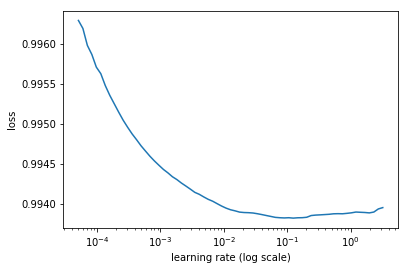

In [45]:
learn.lr_find()
learn.sched.plot()

In [46]:
lr=1e-3
wd=1e-5

lrs = np.array([lr/200,lr/20,lr])/2

In [47]:
learn.fit(lr,1,wds=wd,cycle_len=30,use_clr_beta=(20,10,0.95,0.85))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.993433   0.991638   0.983988   0.958106   0.778383   0.872429   0.758274  
    1      0.99321    0.991534   0.987396   0.974678   0.795081   0.879599   0.776697  
    2      0.993139   0.991471   0.988353   0.979192   0.808853   0.863223   0.796544  
    3      0.993111   0.991555   0.988644   0.973701   0.820952   0.834516   0.817756  
    4      0.993118   0.991561   0.989516   0.9772     0.781784   0.871704   0.76249   
    5      0.993116   0.991569   0.988784   0.977961   0.795347   0.850725   0.783013  
    6      0.99319    0.991959   0.987124   0.97204    0.704887   0.879911   0.672     
    7      0.99319    0.991588   0.986989   0.96212    0.784798   0.868938   0.766499  
    8      0.993183   0.992089   0.984173   0.971164   0.675888   0.873123   0.64039   
    9      0.993201   0.991754   0.987323   0.973186   0.75097    0.852724   0.729885  
    10     0.993214   0.991756   0.986723   0.972769 

[0.9915189504623413,
 0.9895116090774536,
 0.9775006151199341,
 0.8055727744102478,
 0.8600712299346924,
 0.7933478999137878]

In [48]:
learn.save(f'128urn-{S_PREFIX}-tmp')

In [56]:
learn.load(f'128urn-{S_PREFIX}-tmp')

In [57]:
learn.unfreeze()
learn.bn_freeze(True)

In [58]:
lr=1e-3
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])/2

In [59]:
learn.fit(lrs,1,wds=wd,cycle_len=30,use_clr_beta=(20,10,0.95,0.85))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.993066   0.991631   0.989494   0.976029   0.803316   0.864829   0.789612  
    1      0.993064   0.991606   0.989431   0.977662   0.809045   0.856613   0.798333  
    2      0.993048   0.991614   0.989458   0.978729   0.803353   0.864571   0.789726  
    3      0.993045   0.991598   0.989542   0.977521   0.805158   0.863577   0.792111  
    4      0.993049   0.991614   0.989376   0.978526   0.801871   0.867456   0.787325  
    5      0.993037   0.991625   0.989494   0.979155   0.800008   0.868564   0.784851  
    6      0.993033   0.991633   0.989674   0.978205   0.803278   0.864188   0.78975   
    7      0.993033   0.99158    0.989887   0.979777   0.810554   0.86528    0.798231  
    8      0.993026   0.991588   0.989898   0.97814    0.812476   0.855934   0.802725  
    9      0.993031   0.991674   0.989473   0.977969   0.78462    0.88065    0.764094  
    10     0.993004   0.991571   0.989664   0.979242 

[0.9915268874168396,
 0.9904909539222717,
 0.9806595945358276,
 0.81643789768219,
 0.8684296536445618,
 0.8047282671928406]

In [60]:
learn.fit(lrs/4, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.992957   0.991549   0.990451   0.980741   0.81047    0.873533   0.796447  
    1      0.992959   0.991506   0.99066    0.980766   0.824211   0.862774   0.815469  
    2      0.992965   0.991504   0.990658   0.980754   0.821322   0.866706   0.811017  
    3      0.992962   0.991503   0.990596   0.981304   0.820238   0.871965   0.808571  
    4      0.992953   0.991528   0.990639   0.980364   0.8161     0.868117   0.80434   
    5      0.992953   0.991521   0.990587   0.980956   0.815301   0.868909   0.80317   
    6      0.992953   0.991521   0.990588   0.980472   0.815116   0.869024   0.802946  
    7      0.992949   0.991507   0.990564   0.980917   0.820513   0.866623   0.810026  
    8      0.992959   0.991501   0.990636   0.981173   0.821084   0.866415   0.810779  
    9      0.992935   0.99151    0.990644   0.981154   0.817172   0.871918   0.804839  


[0.9915101933479309,
 0.9906439518928528,
 0.9811536860466004,
 0.8171723985671997,
 0.8719176816940307,
 0.8048393535614013]

In [61]:
learn.save(f'128urn-{S_PREFIX}-0')

In [ ]:
learn.load(f'128urn-{S_PREFIX}-0')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x[:10])))

In [ ]:
# py = np.argmax(py,1)

In [ ]:
show_img(denorm(x[0]))

In [ ]:
py.shape

In [ ]:
show_img(py[0][0]>0.5);

In [ ]:
show_img(py[0][1]>0.5);

In [ ]:
show_img(y[0][1]);

## 256x256

In [34]:
ext = '-300'
sz=192
bs=64
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [37]:
lr=1e-4
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])/2

In [36]:
import gc
gc.collect()

0

In [38]:
learn = get_learner(md)

In [39]:
learn.load(f'128urn-{S_PREFIX}-0')

In [40]:
learn.freeze_to(1)

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.987907   0.999475   0.478589   0.279573   0.071932   0.015833   0.644793  


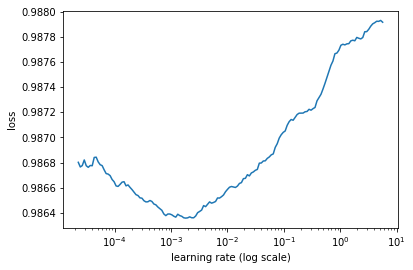

In [68]:
learn.lr_find()
learn.sched.plot()

In [41]:
learn.fit(lr,1,wds=wd, cycle_len=10,use_clr=(5,5))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.986147   0.9853     0.986185   0.967785   0.839673   0.870551   0.832978  
    1      0.985934   0.98524    0.985131   0.957877   0.829153   0.875621   0.819032  
    2      0.985852   0.985064   0.986654   0.968735   0.832151   0.89082    0.819045  
    3      0.985864   0.985176   0.985868   0.962203   0.80923    0.905431   0.788786  
    4      0.985775   0.985028   0.98688    0.968864   0.820264   0.908512   0.801259  
    5      0.985758   0.984852   0.986183   0.975538   0.842045   0.900486   0.828978  
    6      0.98571    0.984758   0.98844    0.978152   0.848751   0.900742   0.837093  
    7      0.985674   0.984665   0.988854   0.976849   0.853588   0.904582   0.841978  
    8      0.985671   0.984733   0.989101   0.976836   0.846331   0.902481   0.83358   
    9      0.985641   0.98465    0.988513   0.977366   0.853521   0.906415   0.841407  



[0.9846500396728516,
 0.9885129189491272,
 0.9773664832115173,
 0.8535209155082703,
 0.9064154624938965,
 0.8414065909385681]

In [42]:
learn.save(f'256urn-{S_PREFIX}-tmp')

In [ ]:
learn.load(f'256urn-{S_PREFIX}-tmp')

In [43]:
learn.unfreeze()
learn.bn_freeze(True)

In [44]:
learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.985578   0.984592   0.988969   0.977784   0.8526     0.908665   0.839796  
    1      0.985544   0.984541   0.989345   0.978449   0.85427    0.908507   0.841849  
    2      0.985548   0.984516   0.989495   0.978751   0.856344   0.907347   0.84463   
    3      0.985539   0.984487   0.989788   0.979182   0.859075   0.906339   0.848169  
    4      0.985531   0.984496   0.989758   0.979667   0.856911   0.908643   0.845038  
    5      0.985534   0.984474   0.989885   0.979531   0.859628   0.906954   0.848711  
    6      0.985525   0.98447    0.98988    0.979527   0.860325   0.906397   0.849682  
    7      0.985524   0.984472   0.989836   0.979789   0.859795   0.906697   0.848971  



[0.9844721508026123,
 0.9898364758491516,
 0.9797889494895935,
 0.8597945308685303,
 0.9066974544525146,
 0.848970890045166]

In [46]:
learn.fit(lrs/20,1,wds=wd, cycle_len=8,use_clr=(20,4))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.985512   0.984474   0.989838   0.979839   0.85931    0.907264   0.848258  
    1      0.985508   0.984479   0.9898     0.979886   0.858458   0.908043   0.847051  
    2      0.985526   0.984478   0.989808   0.979916   0.858484   0.908018   0.847087  
    3      0.985509   0.984478   0.989835   0.979859   0.858005   0.9086     0.846377  
    4      0.985534   0.984472   0.989824   0.979939   0.859066   0.907682   0.847869  
    5      0.98553    0.984472   0.989848   0.979854   0.859031   0.907852   0.847788  
    6      0.985506   0.98447    0.989834   0.979844   0.859524   0.90721    0.848529  
    7      0.985531   0.98447    0.989845   0.979859   0.859401   0.907457   0.848325  



[0.9844704031944275,
 0.9898445463180542,
 0.9798593902587891,
 0.8594012212753296,
 0.9074573159217835,
 0.8483245348930359]

In [47]:
learn.save(f'256urn-{S_PREFIX}')

In [ ]:
learn.load(f'256urn-{S_PREFIX}')

In [73]:
x,y = next(iter(md.trn_dl))

In [ ]:
x.shape

In [80]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x[:8])))

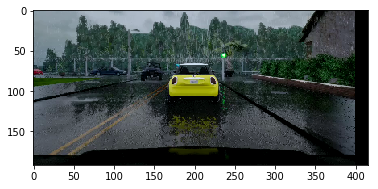

In [84]:
plt.imshow(denorm(x[0]))

In [81]:
py.shape

(8, 2, 192, 416)

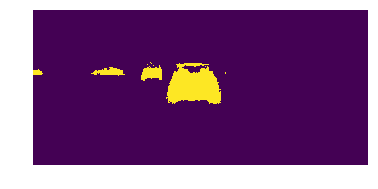

In [83]:
show_img(py[0][0]>0);

In [ ]:
py[-1].shape

In [ ]:
y[-1].shape

In [ ]:
show_img(y[-1]);

### No Crop

In [48]:
ext = '-300'
sz=192
bs=32
md = torch_loader(ext, PATH, bs, sz, workers, False, pseudo_label, val_folder)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [49]:
learn = get_learner(md)

In [50]:
learn.load(f'256urn-{S_PREFIX}')

In [51]:
learn.unfreeze()
learn.bn_freeze(True)

In [54]:
lr=1e-5
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])/2

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.995961   0.996282   0.704761   0.361914   0.0        0.0        0.0       



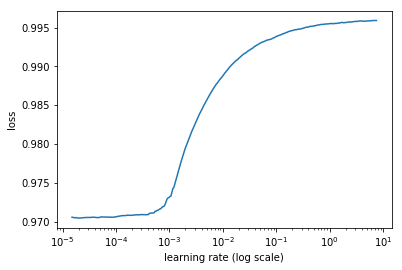

In [53]:
learn.lr_find()
learn.sched.plot()

In [55]:
learn.fit(lr,1,wds=wd, cycle_len=10,use_clr=(5,5))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.970573   0.971183   0.990492   0.98246    0.860054   0.901223   0.851362  
    1      0.970561   0.971076   0.990908   0.980579   0.873752   0.887745   0.871284  
    2      0.970443   0.970964   0.991576   0.984327   0.870182   0.90378    0.863136  
    3      0.970443   0.970944   0.991788   0.982848   0.876851   0.893674   0.873742  
    4      0.970424   0.970851   0.992177   0.984258   0.878044   0.899723   0.873733  
    5      0.970341   0.970882   0.991703   0.984226   0.877395   0.898771   0.873123  
    6      0.970292   0.970896   0.992307   0.985331   0.870656   0.908226   0.862677  
    7      0.970268   0.970838   0.992265   0.985614   0.878351   0.90016    0.87396   
    8      0.970275   0.97082    0.992691   0.984484   0.877322   0.903345   0.871965  
    9      0.970359   0.970822   0.992318   0.986117   0.878075   0.902021   0.873171  



[0.9708219456672669,
 0.9923181939125061,
 0.9861166954040528,
 0.8780753421783447,
 0.9020205736160278,
 0.8731706500053406]

In [56]:
learn.save(f'256urn-{S_PREFIX}-nocrop')

## 512x512

In [34]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'

ext = ''
sz=384
bs=16
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder, val_bs=16)

learn = get_learner(md)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [35]:
# learn.load(f'256urn-{S_PREFIX}')
learn.load(f'256urn-{S_PREFIX}-nocrop')

In [36]:
# learn.freeze_to(1)
learn.unfreeze()
learn.bn_freeze(True)

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.959155   0.995217   0.591205   0.382965   0.161535   0.039053   0.950767  



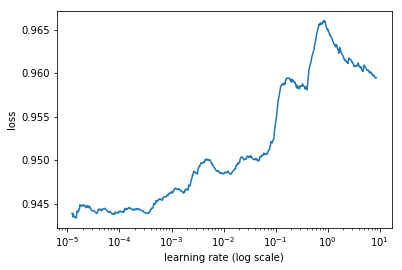

In [61]:
learn.lr_find()
learn.sched.plot()

In [37]:
lr=1e-5
wd=5e-7

In [38]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(10,4))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.941952   0.946847   0.982761   0.953603   0.794791   0.907032   0.773558  
    1      0.941596   0.945821   0.983637   0.951797   0.829644   0.891395   0.818391  
    2      0.941576   0.945635   0.985186   0.959572   0.829577   0.897622   0.816833  
    3      0.941109   0.945592   0.985604   0.964915   0.829228   0.900109   0.815828  



[0.9455917358398438,
 0.9856042408943176,
 0.9649153757095337,
 0.8292278265953064,
 0.9001089978218079,
 0.81582754611969]

In [40]:
learn.fit(lr/10,1, wds=wd, cycle_len=4,use_clr=(10,4))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.941229   0.945684   0.986094   0.96358    0.822704   0.907124   0.806468  
    1      0.941283   0.945631   0.986006   0.964168   0.826357   0.903256   0.811757  
    2      0.941291   0.945399   0.986197   0.963598   0.832793   0.902237   0.819567  
    3      0.941159   0.945407   0.986077   0.965065   0.833406   0.900923   0.820606  



[0.9454074835777283,
 0.9860767483711242,
 0.9650650000572205,
 0.8334061908721924,
 0.9009231090545654,
 0.8206064414978027]

In [41]:
learn.save(f'600urn-{S_PREFIX}-tmp')

In [ ]:
learn.load(f'600urn-{S_PREFIX}-tmp')

In [42]:
learn.unfreeze()
learn.bn_freeze(True)

In [43]:
lrs = np.array([lr/200,lr/20,lr])

In [44]:
learn.fit(lrs/40,1, wds=wd,cycle_len=6,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.941184   0.945406   0.986081   0.965054   0.833343   0.901055   0.820501  
    1      0.941389   0.945407   0.986081   0.965082   0.833232   0.901192   0.820336  
    2      0.9412     0.945402   0.986094   0.96494    0.833489   0.90099    0.820691  
    3      0.941251   0.945401   0.986097   0.964922   0.833565   0.900907   0.820799  
    4      0.941173   0.945402   0.986098   0.96492    0.833453   0.901074   0.820629  
    5      0.941249   0.945402   0.986098   0.964924   0.8334     0.90114    0.820549  



[0.9454022336006165,
 0.9860976719856263,
 0.9649239993095398,
 0.8333996629714966,
 0.9011398148536682,
 0.8205491721630096]

In [ ]:
learn.fit(lrs/40,1, wds=wd,cycle_len=4,use_clr=(20,8))

In [45]:
learn.save(f'600urn-{S_PREFIX}')

In [ ]:
learn.sched.plot_loss()

### No Crop

In [47]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'

ext = ''
sz=384
bs=12
md = torch_loader(ext, PATH, bs, sz, workers, False, pseudo_label, val_folder)

learn = get_learner(md)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [48]:
learn.load(f'600urn-{S_PREFIX}')
# learn.load(f'256urn-{S_PREFIX}-nocrop')

In [49]:
lr=1e-4
wd=5e-7
lrs = np.array([lr/200,lr/20,lr])/2

In [50]:
learn.unfreeze()
learn.bn_freeze(True)

In [51]:
learn.fit(lrs,1, wds=wd,cycle_len=8,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.920627   0.925258   0.986264   0.967583   0.824818   0.893717   0.816678  
    1      0.920181   0.925291   0.986038   0.965809   0.833268   0.873908   0.831052  
    2      0.919808   0.924877   0.986801   0.967622   0.836024   0.879666   0.831707  
    3      0.919912   0.924582   0.987617   0.973707   0.835386   0.891965   0.82864   
    4      0.919803   0.924348   0.988184   0.974861   0.838068   0.892043   0.831183  
    5      0.919496   0.924293   0.988121   0.976456   0.844028   0.885657   0.840317  
    6      0.919333   0.924245   0.988583   0.975847   0.84107    0.893035   0.835149  
    7      0.919556   0.924119   0.988939   0.976086   0.845645   0.889603   0.841396  



[0.9241193252801895,
 0.988938776254654,
 0.9760864973068237,
 0.8456451461836696,
 0.8896026527881622,
 0.8413960760459304]

In [52]:
learn.save(f'600urn-{S_PREFIX}-nocrop-tmp')

In [53]:
learn.load(f'600urn-{S_PREFIX}-nocrop-tmp')

In [54]:
learn.unfreeze()
learn.bn_freeze(True)

In [55]:
learn.fit(lrs/20,1, wds=wd,cycle_len=4,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.919386   0.924129   0.988928   0.976099   0.844958   0.889868   0.840462  
    1      0.919151   0.92412    0.989072   0.975836   0.845181   0.889376   0.841067  
    2      0.91916    0.924145   0.989028   0.976091   0.845143   0.888244   0.841161  
    3      0.919271   0.924096   0.989021   0.976252   0.844741   0.89172    0.840002  



[0.924096309542656,
 0.9890211910009384,
 0.9762516522407532,
 0.8447408901154995,
 0.891720335483551,
 0.8400021025724709]

In [56]:
learn.save(f'600urn-{S_PREFIX}-nocrop-tmp-2')

In [57]:
learn.fit(lrs/100,1, wds=wd,cycle_len=4,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.919418   0.924099   0.98904    0.976201   0.845175   0.890232   0.840752  
    1      0.919271   0.924072   0.988908   0.976572   0.844492   0.893511   0.839302  
    2      0.91908    0.924054   0.988981   0.976452   0.844717   0.893158   0.839471  
    3      0.919557   0.924064   0.988965   0.976469   0.845208   0.891759   0.840371  



[0.9240640300512314,
 0.9889648407697678,
 0.9764689368009567,
 0.8452079289034009,
 0.8917585349082947,
 0.840370644889772]

In [58]:
learn.save(f'600urn-{S_PREFIX}-nocrop')

### Visualize Results

In [36]:
learn.load(f'600urn-{S_PREFIX}-nocrop')

In [99]:
val_it = iter(md.val_dl)

In [111]:
x,y = next(val_it)
res = learn.model(V(x[:10]))
pred = F.sigmoid(res)
py = to_np(pred)

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [106]:
# py = np.argmax(py,1)

In [107]:
idx=9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


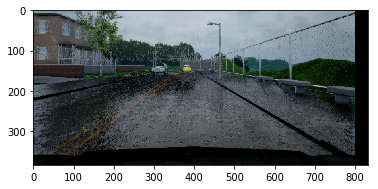

In [108]:
plt.imshow(denorm(x[idx]))

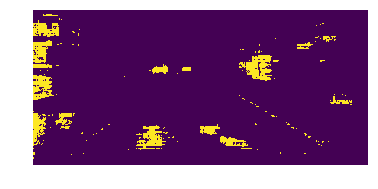

In [109]:
show_img(py[idx][0]>0.5);

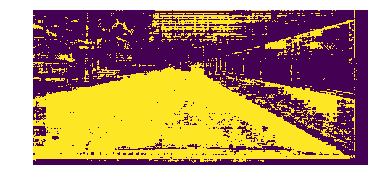

In [104]:
show_img(py[idx][1]>0.5);

In [43]:
y.shape

torch.Size([12, 2, 384, 832])

In [44]:
pred.shape

torch.Size([10, 2, 384, 832])

In [45]:
pred_1 = pred>0.5

In [91]:
def car_f_p_r(pred, targs):
    p2 = F.sigmoid(pred)
    return fbeta_score(p2[:,0,:,:], targs[:,0,:,:], beta=2, threshold=0.5)

In [92]:
def rd_f(pred, targs):
#     mx,idx = torch.max(pred, 1)
    p2 = F.sigmoid(pred)
    f,p,r = fbeta_score(p2[:,1,:,:], targs[:,1,:,:], beta=0.5, threshold=0.5)
    return f

In [93]:
def fbeta_score(y_pred, y_true, beta, threshold=None, eps=1e-9):
    beta2 = beta**2

    if threshold:
        y_pred = torch.ge(y_pred.float(), threshold).float()
    else:
        y_pred = y_pred.float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum()
    precision = true_positive/(y_pred.sum()+(eps))
    recall = true_positive/(y_true.sum()+eps)
    
    fb = (precision*recall)/(precision*beta2 + recall + eps)*(1+beta2)
    
    return fb, precision, recall

In [94]:
pred_1 = torch.ge(pred.float(), 0.5).float()

In [95]:
fbeta_score(pred_1[:,1,:,:].data.float(), y[:10,1,:,:], beta=0.5)

(0.6827504772741737, 0.6467418075433331, 0.8783708353540798)

In [96]:
fbeta_score(pred_1[:,0,:,:].data.float(), y[:10,0,:,:], beta=2)

(0.713703850156314, 0.4584958749768482, 0.8290735859655097)

In [97]:
car_f_p_r(res.data, y[:10])

(0.713703850156314, 0.4584958749768482, 0.8290735859655097)

In [98]:
rd_f(res.data, y[:10])

0.6827504772741737

In [ ]:
py[-1].shape

In [ ]:
y[-1].shape

In [ ]:
show_img(y[idx][0]);

## Save results

In [ ]:
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io import BytesIO, StringIO

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))

In [ ]:
# model_summary(m, [3,608,800])

In [ ]:
# learn.load('1024urn')
load_model(m, str(PATH/f'models/600urn-{S_PREFIX}.h5'))

In [ ]:
# file = sys.argv[-1]
file = 'test_video.mp4'

if file == 'demo.py':
    print("Error loading video")
    quit

# Define encoder function
def encode(array):
    pil_img = Image.fromarray(array)
    buff = BytesIO()
    pil_img.save(buff, format="PNG")
    return base64.b64encode(buff.getvalue()).decode("utf-8")

video = skvideo.io.vread(file)

In [ ]:
# resized_video = np.array([scipy.misc.imresize(f, size=(512,512)) for f in video])

In [ ]:
def normalize(x):
    if np.mean(x) > 1:
        x = x/255
    m,s = imagenet_stats
    x = (x-m)/s
    return x
def preprocess(video):
    f1_norm = normalize(video)
    f1_roll = np.rollaxis(f1_norm, 3, 1)
    f1_pad = np.pad(f1_roll, [(0,0),(0,0),(0,8),(0,0)], mode='constant')
    return f1_pad

In [ ]:
f1 = preprocess(video)

In [ ]:
results = []
for i in range(0,f1.shape[0],8):
    xv = VV(torch.from_numpy(f1[i:i+8]).contiguous().float())
    preds = m(xv)
    mx,idx = torch.max(preds, 1)
    idx_slice = idx[:,:-8,:]
    results.append(idx_slice)

In [ ]:
r_stacked = torch.cat(results,0)
r_np = r_stacked.data.cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(video[index])
    ax2.imshow(r_np[index])

In [ ]:
plot_res(10)

In [ ]:
answer_key = {}

# Frame numbering starts at 1
frame_idx = 1
for frame in r_np:
    # Look for red cars :)
    binary_car_result = (frame==1).astype('uint8')
#     print(np.mean(binary_car_result))
    
    # Look for road :)
    binary_road_result = (frame==2).astype('uint8')

    answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
    
    # Increment frame
    frame_idx+=1

# Print output in proper json format
tester_data = json.dumps(answer_key)
with open('tester_data_multi_take2', 'w') as f:
    f.write(tester_data)
print(json.dumps(answer_key))

### Decoding car

In [ ]:
PATH

In [ ]:
from scipy import misc
def decode(packet):
	img = base64.b64decode(packet)
	filename = PATH/'image.png'
	with open(filename, 'wb') as f:
			f.write(img)
	result = misc.imread(filename)
	return result

with open('results.json') as json_data:
	ans_data = json.loads(json_data.read())
	json_data.close()

In [ ]:
def plot_ans(index):
    ans = decode(ans_data[str(index)][0])
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(r_np[index])
    ax1.set_title('Mine', fontsize=35)
    ax2.imshow(ans)
    ax2.set_title('Answer', fontsize=35)
    ax3.imshow(video[index])
    ax2.set_title('Original', fontsize=35)

In [ ]:
plot_ans(10)

In [ ]:
ans = decode(ans_data['1'][0])

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()